<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/skin_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:11<00:00, 74.8MB/s]
100% 5.20G/5.20G [01:12<00:00, 77.5MB/s]


In [ ]:
import zipfile
zf = "/content/skin-cancer-mnist-ham10000.zip"
target_dir = "/content/dataset/data"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [ ]:
# Reading the data
path = '/content/dataset/data/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [ ]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}


In [ ]:
# Reading Metadata csv file
skin_df = pd.read_csv('/content/dataset/data/HAM10000_metadata.csv')

In [ ]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
# Checking the dataframe info.
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [ ]:
# Image Reading and Resizing.
IMAGE_SIZE = 71
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [01:55<00:00, 86.38it/s]


In [ ]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 71, 71, 3)


In [ ]:
# Creating Target
y = np.array(skin_df['cell_type_idx'])
print(y.shape)

(10015,)


In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [ ]:
# One-Hot Encoding values
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

print(y_train)

In [ ]:
import keras
squeezenet="/content/drive/MyDrive/Copy of squeezenercancer.h5"
vgg16="/content/drive/MyDrive/Copy of Copy of vgg16skincancer.h5"
densenetpath="/content/drive/MyDrive/Copy of densenetskincancer.h5"
inceptionresnetv2="/content/drive/MyDrive/Copy of InceptionResNetV2tpucancer.h5"
mobilenet='/content/drive/MyDrive/mobilnetskincancerfinal.h5'
xception="/content/drive/MyDrive/Copy of xceptionskincancer.h5"
resnet50="/content/drive/MyDrive/Copy of resnet50_skin_cancer.h5"
inceptionv3="/content/drive/MyDrive/Copy of InceptionV3SkinCancer.h5"
alexnet="/content/drive/MyDrive/Copy of AlexNet_skin_scaner_mnist.h5"
paths=[densenetpath,inceptionresnetv2,inceptionv3,mobilenet,resnet50,squeezenet,vgg16,xception,alexnet]
model_name=['densenet','inceptionresnetv2','inceptionv3','mobilenet','resnet50','vgg16','squeezenet','xception',"alexnet"]
model_image_size=[128,128,112,128,112,227,224,71,227]      
def pick_model(model_name):
  model=keras.models.load_model(paths[model_name-1])
  return model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
import time


In [ ]:
def choose_image_and_predict(model_name,image_size):
   
    
   # pneumonia_images = glob('/content/dataset/data/HAM10000_images_part_1'+'/*')
   # img_choice = (random.choice(pneumonia_images))
    img_selection="/content/dataset/data/HAM10000_images_part_1/ISIC_0024307.jpg"
    img = load_img(img_selection, target_size=(image_size, image_size))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    model=pick_model(model_name)
    
    t0=time.time()
    pred = model.predict(x)
    t1=time.time()
    print ("predict time:", round(t1-t0, 3), "s")
    pred_class = np.argmax(pred,axis=1)
    
    if pred_class[0] == 0:
        print("Predicted class: Melanocytic Nevi")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    elif  pred_class[0] == 1:
        print("Predicted class: Melanoma")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence") 
    elif pred_class[0] == 2:
        print("Predicted class: Benign keratosis-like lesions")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    elif  pred_class[0] == 3:
        print("Predicted class: Basal cell carcinoma")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence")  
    
    if pred_class[0] == 4:
        print("Predicted class: Actinic keratoses")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    elif  pred_class[0] == 5:
        print("Predicted class: Vascular lesions")
        print('Likelihood:', pred[0][1].round(4))
        if pred[0][1].round(4) < 0.8:
            print("WARNING, low confidence") 
    elif pred_class[0] == 6:
        print("Predicted class:Dermatofibroma ")
        print("Likelihood:", pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")
    

   


In [ ]:

def display_model_name():
    print('choose model numper: \n')
    for i in range(len(model_name)):
      print(i+1,model_name[i])
    x=int(input(" your selection : "))      
    choose_image_and_predict(x,model_image_size[x-1])

choose model numper: 

1 densenet
2 inceptionresnetv2
3 inceptionv3
4 mobilenet
5 resnet50
6 vgg16
7 squeezenet
8 xception
9 alexnet
 your selection : 4
predict time: 0.636 s
Predicted class: Actinic keratoses
Likelihood: 0.0004
WARNING, low confidence


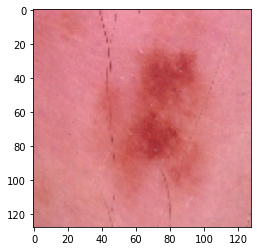

In [ ]:
display_model_name()